Neural Networks with Python

In [1]:
import pandas as pd
import numpy as np

import sklearn

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler, RobustScaler

from keras.models import Model
from keras.optimizers import Adam
from keras.layers import TimeDistributed, GlobalAveragePooling1D, Activation, Input, LSTM, GRU, Dense, Dropout, Flatten, Embedding, SpatialDropout1D, Bidirectional, CuDNNGRU
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers import Flatten, concatenate
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, activations
from keras.layers.recurrent import Recurrent
from keras.engine import InputSpec
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, CSVLogger

import tensorflow as tf
from tensorflow import set_random_seed
from keras import backend as K

# This part required only for GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'
sess = tf.Session(config=config)
K.set_session(sess)

seed = 10293239

from tensorflow import keras
from tensorflow.keras import layers

from math import sqrt

Using TensorFlow backend.


In [2]:
bugs = pd.read_csv('bugs.csv', sep=';', index_col=None)
bugs.head(4)

,CBO,DIT,FanIn,FanOut,LCOM,NOC,RFC,WMC,LOC,Attributes,AttributesInherited,Methods,MethodsInherited,Bugs
0,9,2,1,9,15,0,34,20,122,1,8,6,19,0
1,1,1,1,0,0,0,1,1,4,2,0,1,8,0
2,114,1,102,18,190,6,156,176,484,131,249,20,8,1
3,5,6,1,4,10,0,18,12,33,0,61,5,207,0


In [3]:
# we will make a copy of the main data
bugs_small = bugs[["CBO", "DIT", "FanOut ", "LCOM", "NOC", "LOC", "Attributes ", "AttributesInherited ", "MethodsInherited ", "Bugs "]]
bugs_small

,CBO,DIT,FanOut,LCOM,NOC,LOC,Attributes,AttributesInherited,MethodsInherited,Bugs
0,9,2,9,15,0,122,1,8,19,0
1,1,1,0,0,0,4,2,0,8,0
2,114,1,18,190,6,484,131,249,8,1
3,5,6,4,10,0,33,0,61,207,0
4,23,2,22,820,0,673,7,416,8,0
...,...,...,...,...,...,...,...,...,...,...
992,0,1,0,1,2,3,3,0,8,0
993,9,6,7,15,1,48,3,386,95,0
994,35,3,10,153,9,306,11,52,27,1
995,7,2,7,190,0,87,2,6,30,0


In [4]:
bugs_small.isna().sum()

CBO                     0
DIT                     0
FanOut                  0
LCOM                    0
NOC                     0
LOC                     0
Attributes              0
AttributesInherited     0
MethodsInherited        0
Bugs                    0
dtype: int64

In [5]:
y = bugs_small['Bugs ']
X = bugs_small.drop(['Bugs '], axis=1, inplace=False)

In [6]:
def get_regression_model(n_features=None):
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[n_features]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [7]:
#For regression
np.random.seed(seed)
set_random_seed(seed)

callbacks_list = [
    EarlyStopping(
        monitor='val_loss',
        patience=10)
]

pipeline = []
pipeline.append(('standard', StandardScaler()))

In [8]:
#For regression
EPOCHS = 1000
pipeline.append(('regressor', KerasRegressor(build_fn=get_regression_model,  
                                        epochs=EPOCHS,
                                        batch_size=128, 
                                        verbose=2, 
                                        callbacks=callbacks_list,
                                        n_features=X.shape[1]))) 

In [9]:
model = Pipeline(pipeline)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=seed, stratify=y)

In [11]:
model.set_params(regressor__validation_data=(X_test, y_test)).fit(X_train, y_train)
#odel.fit(X_train, y_train)

#Pipeline.fit(X_train, y_train, regressor__validation_data=(X_test, y_test))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 667 samples, validate on 330 samples
Epoch 1/1000
667/667 - 0s - loss: 1.1850 - mean_absolute_error: 0.4915 - mean_squared_error: 1.1850 - val_loss: 5195.2504 - val_mean_absolute_error: 21.2039 - val_mean_squared_error: 5195.2505
Epoch 2/1000
667/667 - 0s - loss: 0.8461 - mean_absolute_error: 0.4335 - mean_squared_error: 0.8461 - val_loss: 17401.9664 - val_mean_absolute_error: 32.9716 - val_mean_squared_error: 17401.9668
Epoch 3/1000
667/667 - 0s - loss: 0.7604 - mean_absolute_error: 0.4149 - mean_squared_error: 0.7604 - val_loss: 33150.4439 - val_mean_absolute_error: 49.9120 - val_mean_squared_error: 33150.4414
Epoch 4/1000
667/667 - 0s - loss: 0.7105 - mean_absolute_error: 0.4012 - mean_squared_error: 0.7105 - val_loss: 37764.7386 - val_mean_absolute_error: 57.1804 - val_mean_squared_error: 37764.7383
Epoch 5/1000
667/667 - 0s - loss: 0.6896 - mean_absolute_error: 0.4113 - mean_squared_error: 0.

Pipeline(memory=None,
         steps=[('standard',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regressor',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001C08D81DC88>)],
         verbose=False)

In [20]:
example_batch = X_train[:100]
example_result = model.predict(example_batch)
example_result

100/100 - 0s


array([-0.03232694,  0.0586139 , -0.01177015,  0.07142334, -0.09979989,
       -0.06143851,  0.3912144 ,  0.08236326,  0.47730842,  0.11443146,
       -0.04447865, -0.08235677,  0.9878638 ,  0.0634644 ,  0.41754848,
        0.45564038,  0.2662414 ,  0.6307063 ,  0.00557354, -0.05698445,
        0.74651814,  0.09756816,  0.04869653, -0.03291833,  0.2708986 ,
        0.16149215, -0.06836004, -0.04292338, -0.09792123,  1.5559549 ,
       -0.01320199, -0.03807919,  0.11092796,  0.06237192,  0.02242143,
        1.2659161 ,  0.27571854,  0.25702846, -0.01837474, -0.05186637,
        0.02279261,  0.07089013,  0.8157331 , -0.05717012,  0.08364462,
       -0.06212483,  0.20782934, -0.00577248,  1.080954  ,  0.32802728,
        0.09624097,  0.02895645,  0.2897813 ,  0.09218065, -0.03507134,
        0.047507  ,  0.36656967,  0.05611122, -0.03371606,  0.5266205 ,
        0.15095459, -0.0414779 ,  0.03596243,  0.3314016 ,  0.88230556,
        0.08883774,  0.08227734,  0.8456065 ,  0.07034955,  0.01

In [21]:
y_pred = model.predict(X_test)

330/330 - 0s


In [22]:
#For regression
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score

variance = explained_variance_score(y_test, y_pred)
max_error = max_error(y_test, y_pred)
mean_absolute_error = mean_absolute_error(y_test, y_pred)
mean_squared_error = mean_squared_error(y_test, y_pred)
#mean_squared_log_error = mean_squared_log_error(y_test, y_pred)
median_absolute_error = median_absolute_error(y_test, y_pred)
r2_score = r2_score(y_test, y_pred)

"Variance = {:.3f}, Max Error = {:.3f}, Mean Absolute Error = {:.3f}, Mean Squared Error = {:.3f}, Median Absolute Error = {:.3f}, R2 = {:.3f}, RMSE = {:.3f}".format(variance, max_error, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, sqrt(mean_squared_error))

'Variance = 0.442, Max Error = 7.111, Mean Absolute Error = 0.347, Mean Squared Error = 0.653, Median Absolute Error = 0.090, R2 = 0.420, RMSE = 0.808'

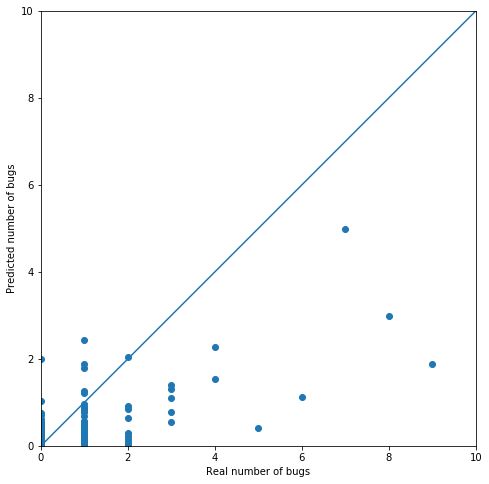

In [23]:
#For regression
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('Real number of bugs')
plt.ylabel('Predicted number of bugs')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

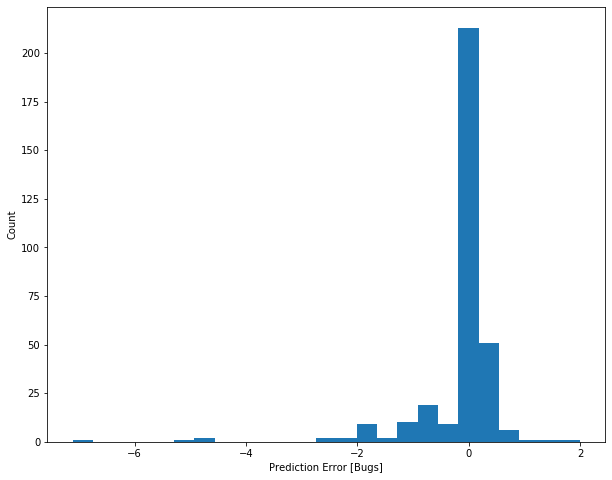

In [17]:
error = y_pred - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Bugs]")
_ = plt.ylabel("Count")